In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"

In [78]:
dataset = pd.read_csv("src/Data.csv")
print(dataset.head())

   Country   Age  Salary Purchased
0   France  44.0   72000        No
1    Spain  27.0   48000       Yes
2  Germany  30.0   54000        No
3    Spain  38.0   61000        No
4  Germany  40.0   69000       Yes


In [79]:
# Basic statistics and dataset overview
print(f"Number of rows: {dataset.shape[0]}")
print(f"Number of columns: {dataset.shape[1]}")
print()

# Display first few rows of the dataset
print(dataset.head())
print()

# Basic statistics
data_desc = dataset.describe(include="all")
print(data_desc)
print()

# Percentage of missing values for each column
missing_values = (dataset.isnull().sum() / dataset.shape[0]) * 100
print(missing_values)


Number of rows: 10
Number of columns: 4

   Country   Age  Salary Purchased
0   France  44.0   72000        No
1    Spain  27.0   48000       Yes
2  Germany  30.0   54000        No
3    Spain  38.0   61000        No
4  Germany  40.0   69000       Yes

       Country        Age        Salary Purchased
count       10   9.000000     10.000000        10
unique       3        NaN           NaN         2
top     France        NaN           NaN        No
freq         4        NaN           NaN         5
mean       NaN  38.777778  64300.000000       NaN
std        NaN   7.693793  11681.419244       NaN
min        NaN  27.000000  48000.000000       NaN
25%        NaN  35.000000  55000.000000       NaN
50%        NaN  38.000000  64000.000000       NaN
75%        NaN  44.000000  71250.000000       NaN
max        NaN  50.000000  83000.000000       NaN

Country       0.0
Age          10.0
Salary        0.0
Purchased     0.0
dtype: float64


# Preprocessing

In [80]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "Purchased"

X = dataset.drop(columns=[target_variable], axis= 1)
Y = dataset[target_variable]

print("...Done.")
print()

print("Y (Target variable):")
print(Y.head())
print("\nX (Features):")
print(X.head())

Separating labels from features...
...Done.

Y (Target variable):
0     No
1    Yes
2     No
3     No
4    Yes
Name: Purchased, dtype: object

X (Features):
   Country   Age  Salary
0   France  44.0   72000
1    Spain  27.0   48000
2  Germany  30.0   54000
3    Spain  38.0   61000
4  Germany  40.0   69000


In [81]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
print("numeric_features:")
print(numeric_features)
print("\ncategorical_features:")
print(categorical_features)

numeric_features:
['Age', 'Salary']

categorical_features:
['Country']


In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [83]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [84]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop="first"))
])

In [85]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [86]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
encoder = LabelEncoder()
Y_train = encoder.fit_transform(y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(y_test[0:5])
Y_test = encoder.transform(y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
...Done.
[[ 1.61706195e+00  1.46885753e+00  0.00000000e+00  0.00000000e+00]
 [ 8.22715727e-01  1.09777773e+00  1.00000000e+00  0.00000000e+00]
 [-1.41104234e-15 -1.00500778e+00  0.00000000e+00  1.00000000e+00]
 [ 2.26956063e-01  8.50391200e-01  0.00000000e+00  0.00000000e+00]
 [ 4.25542617e-01  1.08231607e-01  0.00000000e+00  1.00000000e+00]]

Encoding labels...
...Done
[0 1 0 1 0]
Performing preprocessings on test set...
...Done.
[[2.80858127 2.82948345 1.         0.        ]
 [2.41140816 2.33471038 0.         0.        ]]

Encoding labels...
8     No
7    Yes
Name: Purchased, dtype: object
...Done
[0 1]


# Linear SVM

Let's train a linear SVM and evaluate its performances:

In [87]:
print('Training linear SVM...')
svc = SVC(kernel = 'linear', probability = True) # set probability to True if you plan to use predict_proba()
svc.fit(X_train, Y_train)
print("...Done.")

Training linear SVM...
...Done.


Performances

In [88]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = svc.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = svc.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 1 0 1 0 1 1 1]

Probabilities on training set...
...Done.
[[0.3926606  0.6073394 ]
 [0.53967202 0.46032798]
 [0.36004494 0.63995506]
 [0.6464165  0.3535835 ]
 [0.3634229  0.6365771 ]
 [0.70342992 0.29657008]
 [0.78596462 0.21403538]
 [0.63781474 0.36218526]]



In [89]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = svc.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = svc.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0]

Probabilities on test set...
...Done.
[[0.26362815 0.73637185]
 [0.30080793 0.69919207]]



In [90]:
# Affichage des scores
print(f"Accuracy on training set: {accuracy_score(Y_train, Y_train_pred):.4f}")
print(f"Accuracy on test set: {accuracy_score(Y_test, Y_test_pred):.4f}")
print()

print(f"F1-score on training set: {f1_score(Y_train, Y_train_pred):.4f}")
print(f"F1-score on test set: {f1_score(Y_test, Y_test_pred):.4f}")
print()

Accuracy on training set: 0.8750
Accuracy on test set: 0.5000

F1-score on training set: 0.8889
F1-score on test set: 0.0000



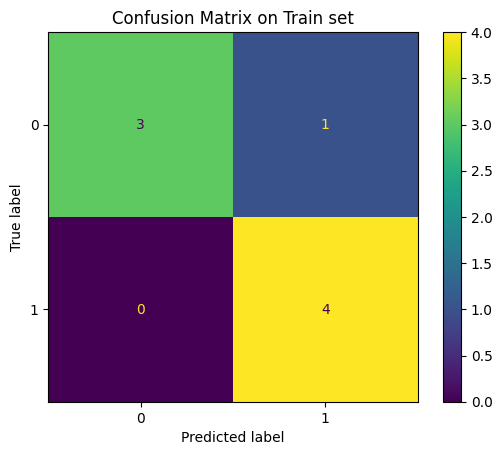

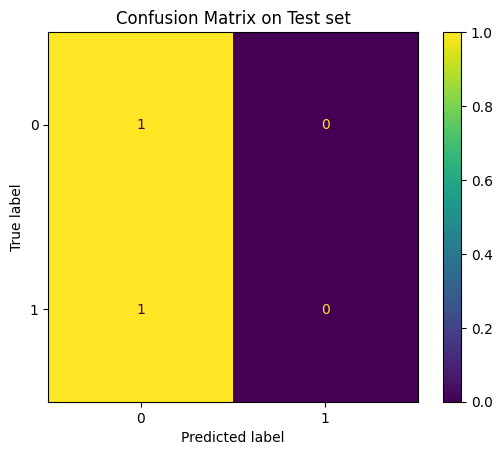

In [91]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svc, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(svc, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

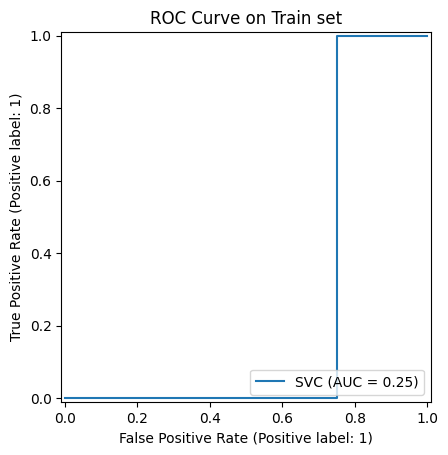

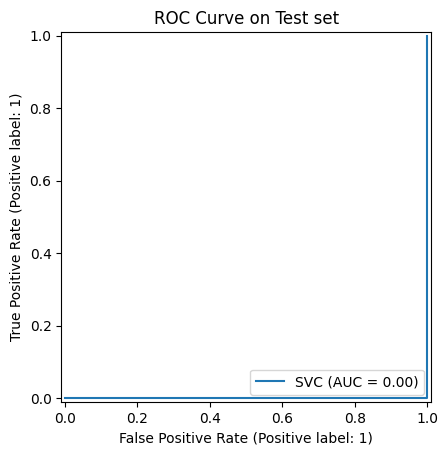

In [92]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(svc, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(svc, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

# Non-linear SVM with radial basis function

Let's train a non-linear SVM with a radial basis function as kernel (with hyperparameter optimization) and evaluate its performances:

Training with hyperparameter optimization
    
For SVM with a RBF kernel, the hyperparameters that are important for overfitting are :

C

gamma

In what follows, you'll see an example of how to tune these hyperparameters with cross-validated grid search :

In [94]:
# Perform grid search
print("Grid search...")
classifier = SVC(kernel = 'rbf', probability = True)

# Grid of values to be tested
params = {
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.1, 1.0, 10.0]
}
gridsearch = GridSearchCV(classifier, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'C': 0.1, 'gamma': 10.0}
Best validation accuracy :  0.5555555555555555


# Performances

In [95]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[0 1 0 1 0 1 0 1]

Probabilities on training set...
...Done.
[[0.45735012 0.54264988]
 [0.54259786 0.45740214]
 [0.4573501  0.5426499 ]
 [0.54259789 0.45740211]
 [0.45735011 0.54264989]
 [0.54259783 0.45740217]
 [0.45735012 0.54264988]
 [0.54259785 0.45740215]]



In [96]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 0]

Probabilities on test set...
...Done.
[[0.5 0.5]
 [0.5 0.5]]



In [97]:
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

accuracy on training set :  1.0
accuracy on test set :  0.5

f1-score on training set :  1.0
f1-score on test set :  0.0


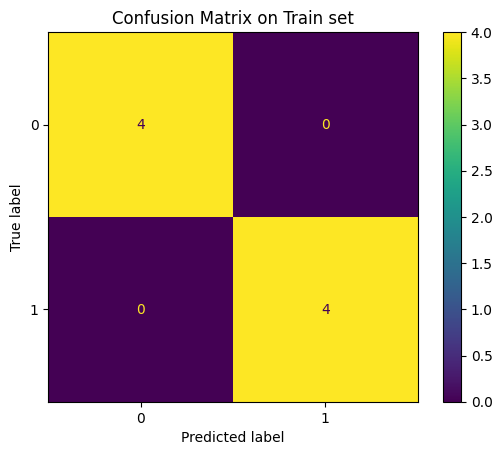

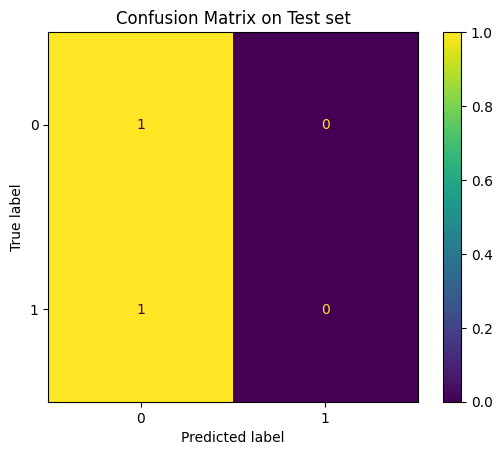

In [98]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

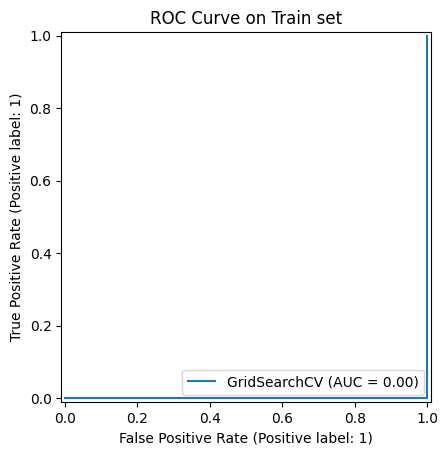

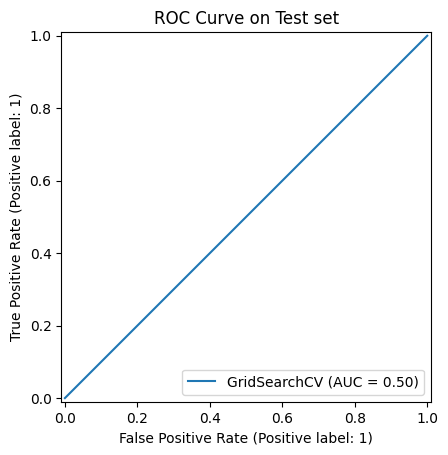

In [99]:
# Visualize ROC curves
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()